# The Effect of Holidays on Sales

In [2]:
# Import necessary packages
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    '''This function will run a selected query in Postgres and 
    return the rows in a pandas dataframe'''
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # Below converts float columns that integer columns, for those that should be integer columns.
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

##### First let us take a look at the holidays in question and whether AGM was open or closed.

In [5]:
# See the holidays in question and whether AGM was open or closed

rollback_before_flag = True
rollback_after_flag = True

query = """
select *
from holidays
"""

print("Table 1: Recorded Holidays, and Holidays AGM was Closed")
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

Table 1: Recorded Holidays, and Holidays AGM was Closed


,holiday_date,description,closed_flag
0,2020-01-01,New Year's Day,False
1,2020-01-20,MLK Day,False
2,2020-02-17,President's Day,False
3,2020-04-12,Easter,False
4,2020-05-10,Mother's Day,False
5,2020-05-25,Memorial Day,False
6,2020-06-21,Father's Day,False
7,2020-07-04,Independence Day,False
8,2020-09-07,Labor Day,False
9,2020-11-11,Veterans Days,False


Based on the above query, we can see there were 11 holidays recorded in 2020, of which AGM was closed for only 2 (Thanksgiving and Christmas). Additionally, the only months that did not record a holiday were March, August, and October.

##### Next we will investigate how the number of sales differed by day of week and by month

In [13]:
# Investigate 
rollback_before_flag = True
rollback_after_flag = True

query = """

select stores.city, extract(dow from sales.sale_date) as dow, to_char(sales.sale_date, 'Day') as day_of_week, count(sales.sale_id) as avg_number_sales
from stores
    join sales
        on stores.store_id = sales.store_id
group by stores.city, dow, day_of_week
order by stores.city asc, dow, day_of_week

"""

df_dow = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
print('Table 2: Average Number of Sales by Day of Week')
df_dow.groupby(['dow', 'day_of_week']).mean()


Table 2: Average Number of Sales by Day of Week


,,avg_number_sales
dow,day_of_week,
0,Sunday,57973.8
1,Monday,40981.8
2,Tuesday,21497.6
3,Wednesday,43457.6
4,Thursday,42993.8
5,Friday,40207.8
6,Saturday,60411.0


The above table 2 is useful to refer to when looking at what day of the week the holidays fall on and how it does or does not disrupt much the expected weekly sales cycle shown by table 2. 

A quick look at this table shows Tuesday as the day with lowest sales on average, with Saturday and Sunday as having the highest number of sales on average. 

The idea of Saturday and Sunday being the days when AGM experiences the highest weekly sales is intriguing given that the targeted demographic of AGM's meals are young professionals and/or affluent areas. As such it might be expected to see greater sales during the week. But it is also possible that sales are highest during the weekend when the perceived main customer base is preparing for their upcoming work week - part of which is buying their lunches for the week instead of on the day when they may not have time to go to the grocery store in their lunch break. 

In [7]:
# See how number of sales have done by month

rollback_before_flag = True
rollback_after_flag = True

query = """

select extract(month from sales.sale_date) as month_number, to_char(sale_date, 'Month') as month_name, count(sales.sale_id) as number_sales_monthly, sum(sales.total_amount) as total_sales_monthly, sum(total_amount)/count(sale_id) as avg_usd_per_sale_monthly
from stores
    join sales
        on stores.store_id = sales.store_id
group by month_number, month_name
order by month_number, month_name asc

"""

df_month = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

print("Table 3: Number of Sales, Total Sales Amount, and Average USD/Sale, by Month")
df_month

Table 3: Number of Sales, Total Sales Amount, and Average USD/Sale, by Month


,month_number,month_name,number_sales_monthly,total_sales_monthly,avg_usd_per_sale_monthly
0,1,January,121955,7803828,63.989406
1,2,February,117984,7574280,64.197518
2,3,March,136653,8779620,64.247547
3,4,April,128155,8251284,64.385190
4,5,May,124380,7977840,64.140859
5,6,June,126248,8124108,64.350390
6,7,July,124290,7993044,64.309631
7,8,August,140467,9029808,64.284195
8,9,September,117974,7578960,64.242630
9,10,October,138731,8895108,64.117667


Graphs 1, 2, 3, 4


<ipython-input-8-8ca3d596d2b9>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in df_month['number_sales_monthly']])
<ipython-input-8-8ca3d596d2b9>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')


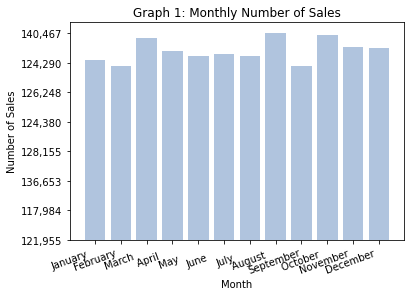

<ipython-input-8-8ca3d596d2b9>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in df_month['total_sales_monthly']])
<ipython-input-8-8ca3d596d2b9>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')


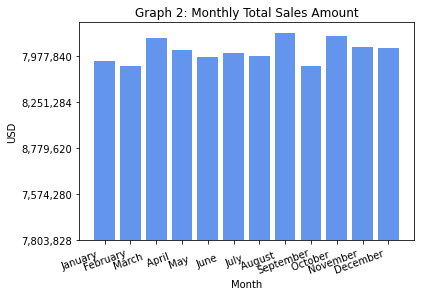

<ipython-input-8-8ca3d596d2b9>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')


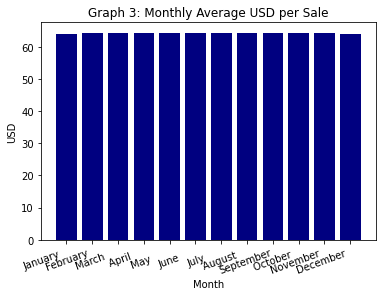

<ipython-input-8-8ca3d596d2b9>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')


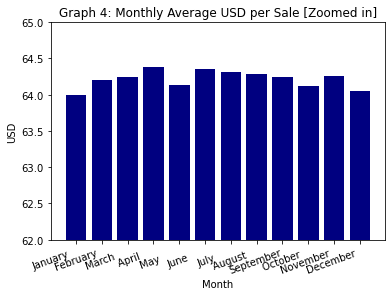

In [8]:
# Graph the Above table 

print('Graphs 1, 2, 3, 4')

plt.bar(df_month['month_name'], df_month['number_sales_monthly'], color='lightsteelblue')
plt.title('Graph 1: Monthly Number of Sales')
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in df_month['number_sales_monthly']])
plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')
plt.show()

plt.bar(df_month['month_name'], df_month['total_sales_monthly'], color='cornflowerblue')
plt.title('Graph 2: Monthly Total Sales Amount')
plt.xlabel('Month')
plt.ylabel('USD')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in df_month['total_sales_monthly']])
plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')
plt.show()

plt.bar(df_month['month_name'], df_month['avg_usd_per_sale_monthly'], color='navy')
plt.title('Graph 3: Monthly Average USD per Sale')
plt.xlabel('Month')
plt.ylabel('USD')
plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')
plt.show()

plt.bar(df_month['month_name'], df_month['avg_usd_per_sale_monthly'], color='navy')
plt.title('Graph 4: Monthly Average USD per Sale [Zoomed in]')
plt.xlabel('Month')
plt.ylabel('USD')
plt.ylim(62, 65)
plt.gca().set_xticklabels(df_month['month_name'],rotation=20, ha='right')
plt.show()

Looking at the above graphs 1 and 2 showing the number of monthly sales, and total monthly sales repsectively, it looks like there has been some variation in regards to both indicators, with both seeming to follow a similar pattern. Namely, the peak seems to have been in August, followed by October then March. This was seen for both number of sales and total sales amount monthly. Coincidentally, these are the same three months that did not have any holidays recorded, but given that most holidays (with the exceptions of Thanksgiving and Christmas) AGM was open, this fact may not be of that great importance. The lowest 2 months were February and September. 

Moving towards the monthly average dollar amount per sale, looking at graph 3, there does not seem to be much of a difference. Graphs 3 and 4 take a closer zoom in to the monthly averages and we can see that there is some variation by month, but the actual range of average dollar amount per sale is forty cents. This is important to keep in mind, especially when looking at graph 4 (the zoom in). Given the numbers, one could say that the average sale amount has been relatively consistent at an average of $64.22 (question 1.1.9). 

To continue our investigation on the effect of holidays on sales, we will focus on number of sales only, as total sales amount follows a very close pattern to number of sales (explained above), and monthly average dollar amount per sale has remained relatively consistent. 

We will now move on to investigating the number of daily sales in the week leading up to and after the aforementioned holidays. 

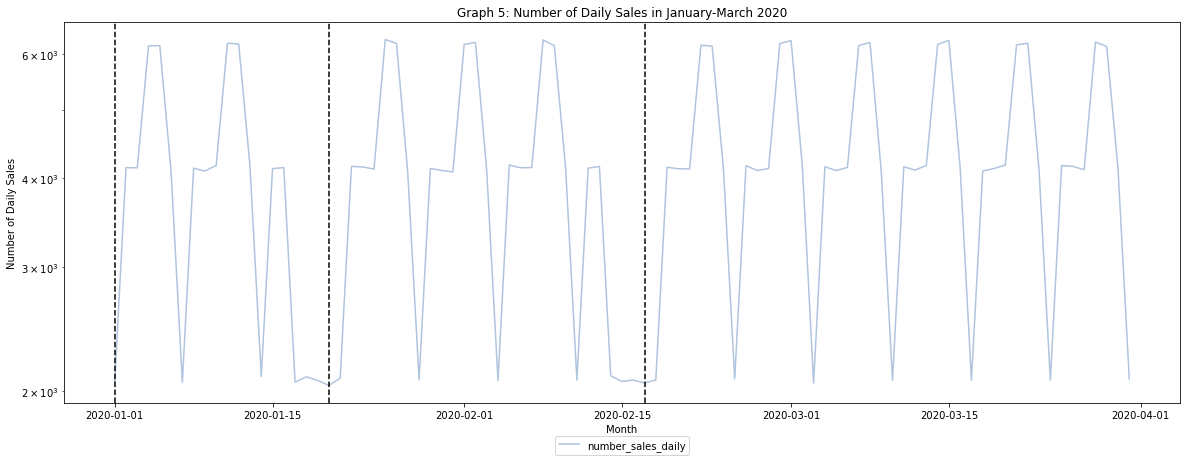

In [9]:
# Q1 2020
rollback_before_flag = True
rollback_after_flag = True

query = """
select sale_date, count(sales.sale_id) as number_sales_daily, sum(sales.total_amount) as total_sales_daily, sum(total_amount)/count(sale_id) as avg_usd_per_sale_daily
from sales
where sale_date between '2020-01-01' and '2020-03-31'
group by sale_date
"""

df_nye = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
fig_1 = df_nye.plot('sale_date', 'number_sales_daily', figsize = (20,7), color='lightsteelblue')
fig_1.set_title('Graph 5: Number of Daily Sales in January-March 2020')
fig_1.set_xlabel('Month')
fig_1.set_ylabel('Number of Daily Sales')
fig_1.axvline("2020-01-01", color = "black", linestyle = 'dashed') #New Years Day
fig_1.axvline("2020-01-20", color = "black", linestyle = 'dashed') #MLK Day
fig_1.axvline("2020-02-17", color = "black", linestyle = 'dashed') #President's Day
fig_1.set_yscale('log')
fig_1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol= 2)

The above graph 5 looks at the number of daily sales between January and March of 2020 (Q1 2020). This first quarter of the year includes New Years Day, MLK Day, and Presidents Day as the recorded holidays marked by the black dashed lines from left to right respectively. AGM was open on all three days. 

For New Years day there is no data available before that date, as such it is difficult to ascertain why that day started off low (especially considering they were open). But for the other two holidays, it seems that there may have been a bit of a lull in the few days leading up to those holidays, but then it seems to pick up a day or two after. It should be noted that these two holidays took place on Mondays. Perhaps this could imply that over the long weekend, more young professional people (one of the main target demographics) are likely to have a lower need to order food - possibly because they have more time to get meals in other ways during a long weekend (e.g. cooking or going to a restaurant) or maybe because they are out of town. 

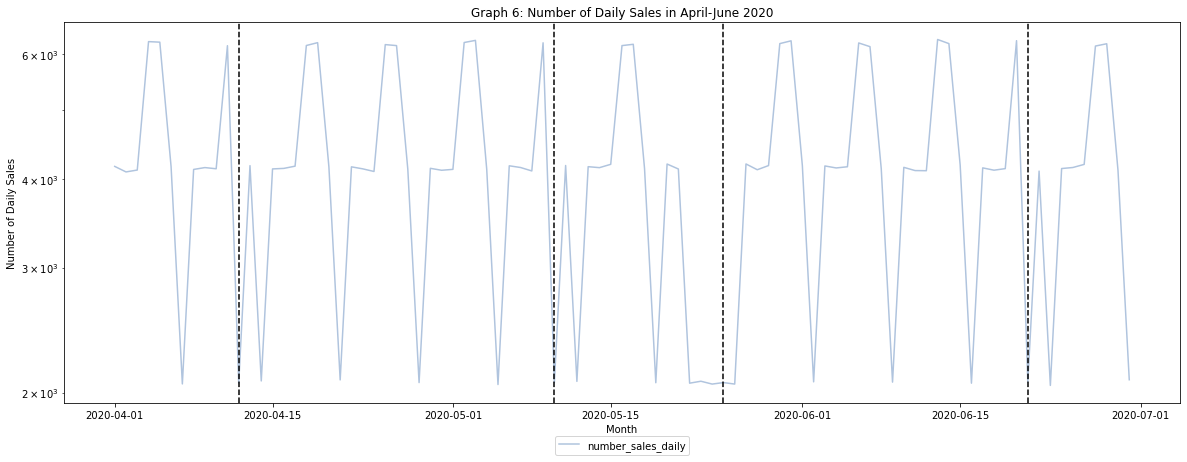

In [10]:
# Q2 2020
rollback_before_flag = True
rollback_after_flag = True

query = """
select sale_date, count(sales.sale_id) as number_sales_daily, sum(sales.total_amount) as total_sales_daily, sum(total_amount)/count(sale_id) as avg_usd_per_sale_daily
from sales
where sale_date between '2020-04-01' and '2020-06-30'
group by sale_date
"""

df_apr = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
fig_1 = df_apr.plot('sale_date', 'number_sales_daily', figsize = (20,7), color='lightsteelblue')
fig_1.set_title('Graph 6: Number of Daily Sales in April-June 2020')
fig_1.set_xlabel('Month')
fig_1.set_ylabel('Number of Daily Sales')
fig_1.axvline("2020-04-12", color = "black", linestyle = 'dashed') #Easter
fig_1.axvline("2020-05-10", color = "black", linestyle = 'dashed') #Mother's Day
fig_1.axvline("2020-05-25", color = "black", linestyle = 'dashed') #Memorial Day
fig_1.axvline("2020-06-21", color = "black", linestyle = 'dashed') #Father's Day
fig_1.set_yscale('log')
fig_1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol= 2)

In the second quarter of 2020 (April-June), four holidays were recorded (marked by black dashed line in graph 6): Easter, Mother's Day, Memorial Day, and Father's Day. Of these four holidays, only Memorial day was observed on a Monday, the rest on a Sunday. AGM was open on all of these holidays. 

As seen in the query from question 1.1.5 and 1.1.6 on sales on different days of the week, Tuesday tends to be the day of the week with the lowest sales. This explains the expected continued dip after Memorial Day (third black dashed line from the left). In fact the pattern preceding Memorial Day looks very similar to what was seen right before MLK and President's day in Q1 2020 (graph 5). 

For the other three holidays taking place on Sundays, the number of sales on those days seems comparable to the number of sales expected on Tuesdays - i.e. quite low. Given that these holidays also tend to be family centric holidays (Easter, Mother's Day, Father's Day), and that they take place on the weekend, it is likely that a portion of the customer base went to their homes for the weekend where it the likelihood of them eating from AGM will be much lower than eating either at their family homes or nearby (could be out of town). The Mondays right after seem to have a big increase in sales before dropping down to the expected Tuesday slumps. 

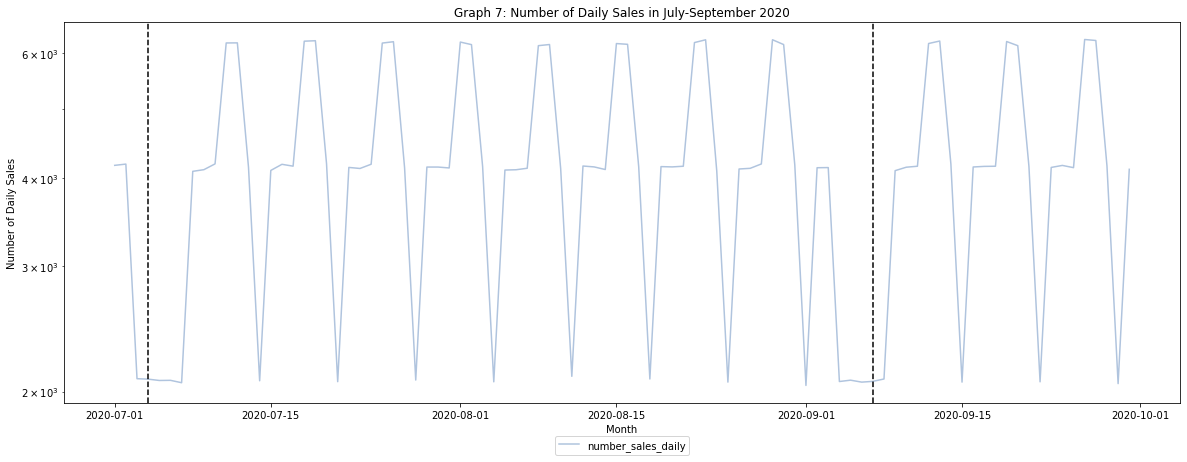

In [11]:
# Q3 2020
rollback_before_flag = True
rollback_after_flag = True

query = """
select sale_date, count(sales.sale_id) as number_sales_daily, sum(sales.total_amount) as total_sales_daily, sum(total_amount)/count(sale_id) as avg_usd_per_sale_daily
from sales
where sale_date between '2020-07-01' and '2020-09-30'
group by sale_date
"""

df_may = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
fig_1 = df_may.plot('sale_date', 'number_sales_daily', figsize = (20,7), color='lightsteelblue')
fig_1.set_title('Graph 7: Number of Daily Sales in July-September 2020')
fig_1.set_xlabel('Month')
fig_1.set_ylabel('Number of Daily Sales')
fig_1.set_yscale('log')
fig_1.axvline("2020-07-04", color = "black", linestyle = 'dashed') #Independence Day
fig_1.axvline("2020-09-07", color = "black", linestyle = 'dashed') #Labor Day
fig_1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol= 2)

Between July and September 2020 (Q3), the two observed holidays were Independence Day and Labor Day - the left and right black dashed lines in graph 7 respectively. AGM was open on both days. 

In the days leading up to labor day, the same pattern was observed as in the days leading up to MLK Day, Presidents Day, and Memorial Day - i.e. the other holidays taking place on Mondays. Culturally in the United States, Labor Day is known to be the last chance to go on a "summer" holiday and it is known for many people to go out of town. Like for the other holidays taking place on Mondays, extended weekends make it easier to plan vacations where people may not be in town. And given the demographic AGM seems to target with their ready made food for young professionals and/or affluent areas, AGM seems to be associated with being more as a meal one has if they don't have time - especially since they are sold in grocery stores (where people go to get a quick meal). After the expected Tuseday Slump, the number of sales picks up again. 

Independence day took place on a Saturday (first dashed black line). Usually most companies gave people either that preceding Friday or following Monday as a day off in 2020, which would explain why the day before and few days after had a low number of sales. 

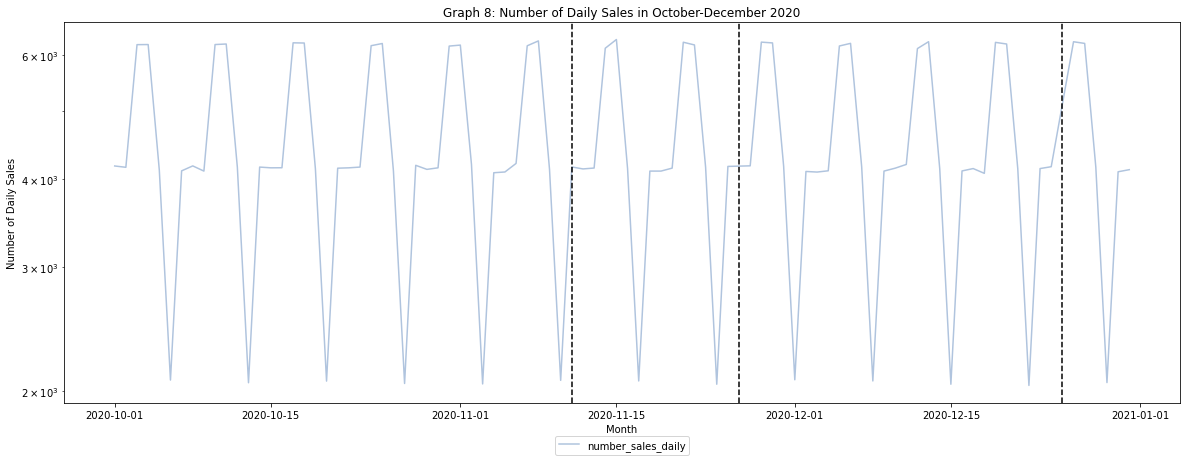

In [12]:
# Q4 2020
rollback_before_flag = True
rollback_after_flag = True

query = """
select sale_date, count(sales.sale_id) as number_sales_daily, sum(sales.total_amount) as total_sales_daily, sum(total_amount)/count(sale_id) as avg_usd_per_sale_daily
from sales
where sale_date between '2020-10-01' and '2020-12-31'
group by sale_date
"""

df_may = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
fig_1 = df_may.plot('sale_date', 'number_sales_daily', figsize = (20,7), color='lightsteelblue')
fig_1.set_title('Graph 8: Number of Daily Sales in October-December 2020')
fig_1.set_xlabel('Month')
fig_1.set_ylabel('Number of Daily Sales')
fig_1.axvline("2020-11-11", color = "black", linestyle = 'dashed') #Veterans Day
fig_1.axvline("2020-11-26", color = "black", linestyle = 'dashed') #Thanksgiving 
fig_1.axvline("2020-12-25", color = "black", linestyle = 'dashed') #Christmas
fig_1.set_yscale('log')
fig_1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol= 2)

Graph 8 shows the number of daily sales for the last quarter of 2020 - October-December. Three holidays were observed in this period, which are marked by the black dashed lines in the graph in the following order: Veterans Day, Thanksgiving, and Christmas. Of these holidays, AGM was closed only on the latter 2 days. 

Given that the number of sales on the days AGM was closed was not zero, implies that the grocery stores where AGM meals were being sold were open and that day old meals were likely being sold instead of freshly made that day.

The holidays (in chronological order) took place on a Wednesday, Thursday and Friday. Normally during these days the number of sales is generally higher than say Tuesday.  

For Veterans Day, which is not guaranteed as a holiday for everyone outside of federal government offices, it is understandable as to why sales for that day may not have been too affected. Given that it takes place in the middle of the week, it is more likely that people are still in town during the week to go to work the day before and after. 

Thanksgiving and Christmas, AGM was closed and there is no record for these two days in the SQL database. This means that the graph skips these days and it isn't shown (i.e. it goes from November 24th to 26th). What we can say is that in the days leading and following Thanksgiving and Christmas, the number of sales did not seem to be too affected. This could possibly be because those grocery stores were open and customers fell back to their habits. But this is something that could be looked further into. 

## Key Takeaway and Concluding Points:

**The day of the week the holiday takes place on is telling of the what AGM can expect of its sales.** For example, when holidays would fall on Mondays leading to the possibility of a 3-day weekend (or Independence Day that fell on a Saturday but usually people get at least one day off to make it a 3-day weekend), sales tended to be lower in the days leading up to it and until the expected slump on Tuesday. This could be because more people are possibly out of town or don't need to get a quick meal from the grocery store on those days. But holidays that took place on Sundays, tended to see a sharp drop in sales - possible because those holidays were more family centric where the desire for a ready made meal from a grocery store may be less. 

A next point in further research could be investigate deeper as to why the days surrounding Thanksgiving and Christmas do not seem to be more affected than one might have expected. 

*Note: Given that in 'EDA_Sales' we saw how the total sales amounts by day of week has a similar rise and drop pattern for all stores, that the sales amount and number of sales is closely related (graphs 1 and 2 on this page), and that decisions to branch into other cities were based on similar criteria, a decision was made to focus on overall patterns rather than by store. 